In [1]:
import pandas as pd
import numpy as np

In [3]:
url = 'https://raw.githubusercontent.com/azou0/Dataset/refs/heads/main/kick.csv'

In [4]:
df = pd.read_csv(url)

C:\Users\23179\AppData\Local\Temp\ipykernel_34004\4176769558.py:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


In [5]:
# Calculate proportion of values of the target variable

before_counts = df["IsBadBuy"].value_counts(dropna=False)
before_proportion = before_counts / len(df)

print("Before preprocessing:")
print(pd.DataFrame({"Count": before_counts, "Proportion": before_proportion}))

Before preprocessing:
          Count  Proportion
IsBadBuy                   
0         36105    0.870503
1          5371    0.129497


Before preprocessing, the target variable IsBadBuy consisted of:

Class 0 (Good Buy): 0.870503% of records

Class 1 (Bad Buy):  0.129497% of records

Missing: 0% of records

Initial check

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41476 entries, 0 to 41475
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   PurchaseID                         41476 non-null  int64  
 1   PurchaseTimestamp                  41476 non-null  int64  
 2   PurchaseDate                       41476 non-null  object 
 3   Auction                            41432 non-null  object 
 4   VehYear                            41432 non-null  float64
 5   Make                               41432 non-null  object 
 6   Color                              41432 non-null  object 
 7   Transmission                       41432 non-null  object 
 8   WheelTypeID                        41432 non-null  object 
 9   WheelType                          41380 non-null  object 
 10  VehOdo                             41432 non-null  float64
 11  Nationality                        41432 non-null  obj

From the initial inspection, the dataset contained several variables stored as object (string) or incorrect numeric types.

PurchaseDate was stored as object, PurchaseTimestamp was stored as integer.

Many price and odometer variables (MMR..., VehBCost, WarrantyCost, etc.) were stored as object instead of numeric.

Columns such as PRIMEUNIT, IsOnlineSale were stored as object instead of integers.

Manufacturer, color, region, and similar fields were stored as object instead of category type.

conversion process

In [7]:

df["PurchaseDate"] = pd.to_datetime(df["PurchaseDate"], errors="coerce")


df["PurchaseTimestamp"] = pd.to_datetime(df["PurchaseTimestamp"], unit="s", errors="coerce")


numeric_columns = [
    "VehYear", "VehOdo", "VehBCost", "WarrantyCost",
    "MMRAcquisitionAuctionAveragePrice", "MMRAcquisitionAuctionCleanPrice",
    "MMRAcquisitionRetailAveragePrice", "MMRAcquisitonRetailCleanPrice",
    "MMRCurrentAuctionAveragePrice", "MMRCurrentAuctionCleanPrice",
    "MMRCurrentRetailAveragePrice", "MMRCurrentRetailCleanPrice",
    "MMRCurrentRetailRatio"
]
for column in numeric_columns:
    df[column] = pd.to_numeric(df[column], errors="coerce")


binary_columns = ["IsOnlineSale"]
for column in binary_columns:
    df[column] = pd.to_numeric(df[column], errors="coerce").astype("Int64")


category_columns = [
    "Auction", "Make", "Color", "Transmission", "WheelTypeID", "WheelType",
    "Nationality", "Size", "AUCGUART", "VNST","TopThreeAmericanName", 
]
for column in category_columns:
    df[column] = df[column].astype("category")


print(df.dtypes)

C:\Users\23179\AppData\Local\Temp\ipykernel_34004\1863944543.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["PurchaseDate"] = pd.to_datetime(df["PurchaseDate"], errors="coerce")


PurchaseID                                    int64
PurchaseTimestamp                    datetime64[ns]
PurchaseDate                         datetime64[ns]
Auction                                    category
VehYear                                     float64
Make                                       category
Color                                      category
Transmission                               category
WheelTypeID                                category
WheelType                                  category
VehOdo                                      float64
Nationality                                category
Size                                       category
TopThreeAmericanName                       category
MMRAcquisitionAuctionAveragePrice           float64
MMRAcquisitionAuctionCleanPrice             float64
MMRAcquisitionRetailAveragePrice            float64
MMRAcquisitonRetailCleanPrice               float64
MMRCurrentAuctionAveragePrice               float64
MMRCurrentAu

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

Checking redundancy

To reduce the complexity of the modelling process, we need to reduce the dimensionality of the dataset. 
We identify and remove columns that carry overlapping information.
Several columns might be redundant. The dataset contains multiple price variables for different market types. WheelTypeID and WheelType describe the same feature in different formats. Also, PurchaseDate and PurchaseTimestamp both represent the purchase date/time.
I checked the correlation between those columns.

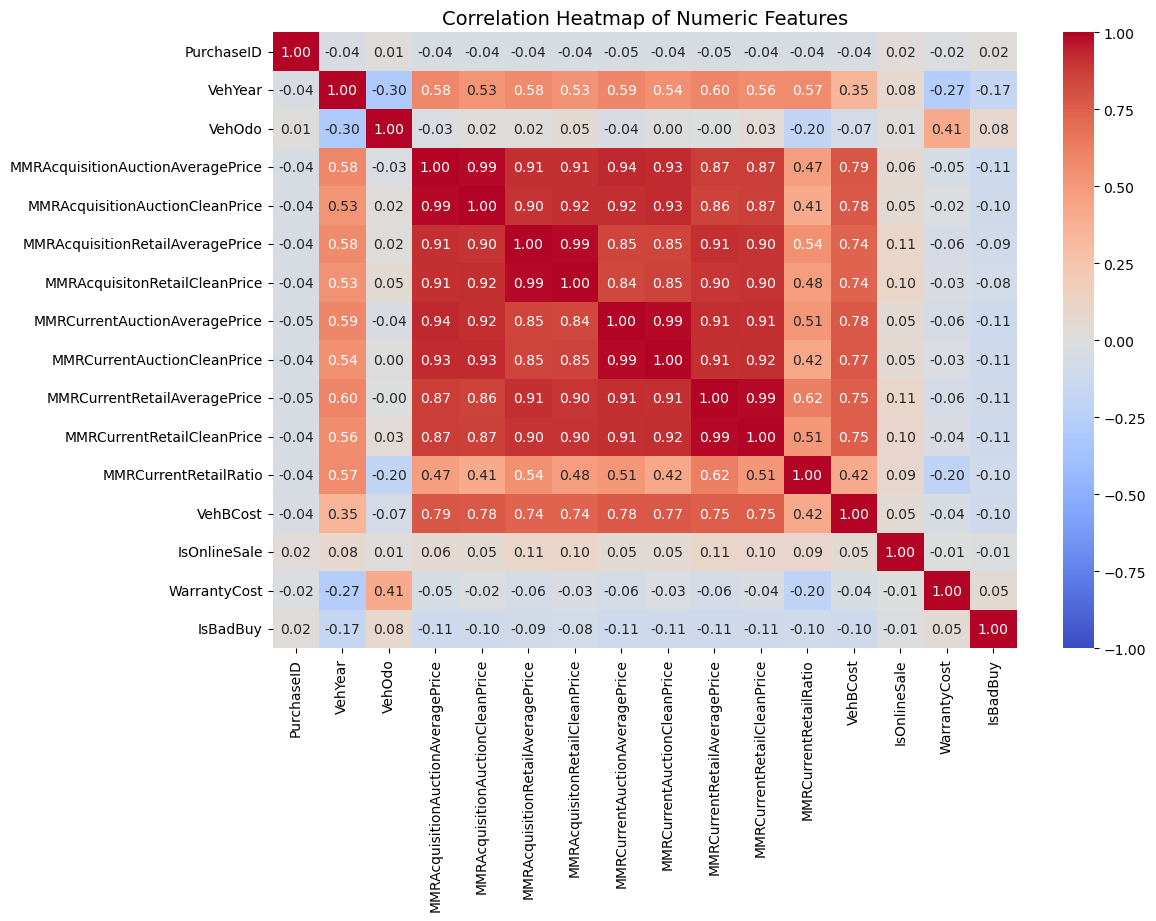

In [10]:

numeric_df = df.select_dtypes(include=["float64", "int64", "Int64"])


corr_matrix = numeric_df.corr()


plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Numeric Features", fontsize=14)
plt.show()

In [11]:
# Select only the price columns
mmr_cols = [
    "MMRAcquisitionAuctionAveragePrice",
    "MMRAcquisitionAuctionCleanPrice",
    "MMRAcquisitionRetailAveragePrice",
    "MMRAcquisitonRetailCleanPrice",
    "MMRCurrentAuctionAveragePrice",
    "MMRCurrentAuctionCleanPrice",
    "MMRCurrentRetailAveragePrice",
    "MMRCurrentRetailCleanPrice",
    "MMRCurrentRetailRatio"
]

mmr_df = df[mmr_cols]

# Check correlations
correlation_matrix = mmr_df.corr()

print("Correlation Matrix:\n", correlation_matrix)

Correlation Matrix:
                                    MMRAcquisitionAuctionAveragePrice  \
MMRAcquisitionAuctionAveragePrice                           1.000000   
MMRAcquisitionAuctionCleanPrice                             0.990273   
MMRAcquisitionRetailAveragePrice                            0.910271   
MMRAcquisitonRetailCleanPrice                               0.909688   
MMRCurrentAuctionAveragePrice                               0.935041   
MMRCurrentAuctionCleanPrice                                 0.929234   
MMRCurrentRetailAveragePrice                                0.868028   
MMRCurrentRetailCleanPrice                                  0.867273   
MMRCurrentRetailRatio                                       0.471789   

                                   MMRAcquisitionAuctionCleanPrice  \
MMRAcquisitionAuctionAveragePrice                         0.990273   
MMRAcquisitionAuctionCleanPrice                           1.000000   
MMRAcquisitionRetailAveragePrice                

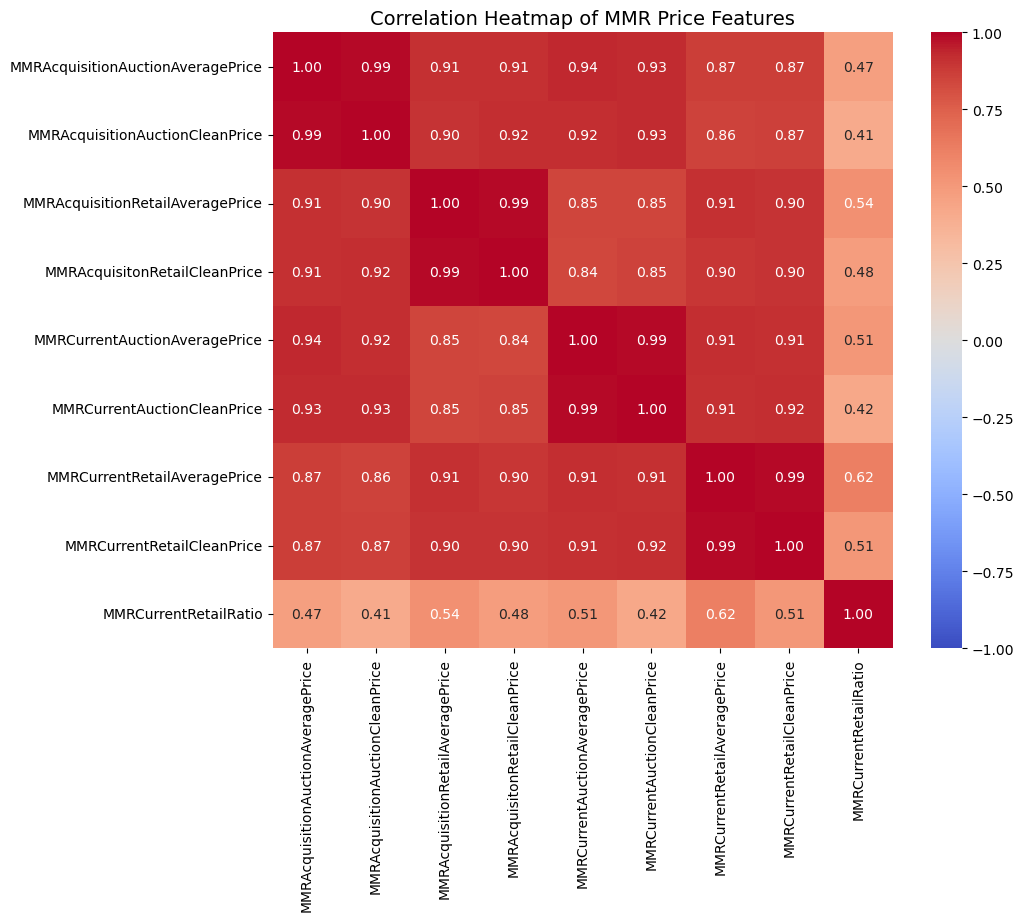

In [12]:
# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap of MMR Price Features", fontsize=14)
plt.show()

The outputs show that several pairs exhibited near-perfect correlations (0.99), specifically between the “average” and “clean” condition prices for the same market and time period. It means that hese columns contain essentially the same information.To reduce redundancy while preserving information, one column from each highly correlated pair was retained, and the corresponding “clean” price variables were removed. The MMRCurrentRetailRatio was retained due to its moderate correlations with other features.

In [13]:
#I store the categirical cols to a new df to compute the correlation.

cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = df.select_dtypes(include=["float64", "int64", "Int64"]).columns.tolist()


df_encoded = df.copy()
for col in cat_cols:
    df_encoded[col] = df_encoded[col].astype("category").cat.codes


pairs = [
    ("WheelTypeID", "WheelType"),
    ("Make", "Nationality"),
    ("TopThreeAmericanName", "Make")
]


for a, b in pairs:
    if a in df_encoded.columns and b in df_encoded.columns:
        corr_val = df_encoded[[a, b]].corr().iloc[0, 1]
        print(f"Correlation between {a} and {b}: {corr_val:.4f}")
    else:
        print(f"One or both columns not found: {a}, {b}")

Correlation between WheelTypeID and WheelType: 0.2583
Correlation between Make and Nationality: 0.5453
Correlation between TopThreeAmericanName and Make: 0.5002


The output shows that the correlations between WheelTypeID and WheelType, Make and Nationality, and TopThreeAmericanName and Make are not very high. So, these columns are retained.

In [14]:
# Drop redundant columns

redundant_columns = [ "MMRAcquisitionAuctionCleanPrice",
    "MMRAcquisitonRetailCleanPrice",
    "MMRCurrentAuctionCleanPrice",
    "MMRCurrentRetailCleanPrice",
    "PurchaseDate"]

df = df.drop(columns=redundant_columns)

Handling missing values

In [15]:
print(df.isnull().sum().sort_values(ascending=False))

MMRCurrentRetailRatio                538
MMRCurrentRetailAveragePrice         251
MMRCurrentAuctionAveragePrice        231
WheelType                             96
VehBCost                              73
MMRAcquisitionAuctionAveragePrice     67
MMRAcquisitionRetailAveragePrice      54
IsOnlineSale                          46
WheelTypeID                           44
VehOdo                                44
Nationality                           44
WarrantyCost                          44
TopThreeAmericanName                  44
Transmission                          44
Color                                 44
Make                                  44
VehYear                               44
PRIMEUNIT                             44
AUCGUART                              44
VNST                                  44
Auction                               44
Size                                  44
ForSale                                0
PurchaseID                             0
PurchaseTimestam

I checked the unique values of each column.
This helps us quickly see if there are unexpected values. I exclude obvious identifiers like PurchaseID and PurchaseTimestamp to get a cleaner output.

In [16]:
id_columns = ["PurchaseID", "PurchaseTimestamp"]

# Loop through non-identifier columns
for col in df.columns:
    if col not in id_columns:
        unique_vals = df[col].unique()
        print(f"Column: {col}")
        print(f"Unique values ({len(unique_vals)}): {unique_vals}")
        print("-" * 50)

Column: Auction
Unique values (4): ['OTHER', 'MANHEIM', NaN, 'ADESA']
Categories (3, object): ['ADESA', 'MANHEIM', 'OTHER']
--------------------------------------------------
Column: VehYear
Unique values (11): [2008. 2007. 2004. 2006. 2005. 2003. 2009. 2001. 2002.   nan 2010.]
--------------------------------------------------
Column: Make
Unique values (31): ['DODGE', 'CHRYSLER', 'CHEVROLET', 'PONTIAC', 'MITSUBISHI', ..., 'SCION', 'LEXUS', 'MINI', 'VOLVO', NaN]
Length: 31
Categories (30, object): ['ACURA', 'BUICK', 'CADILLAC', 'CHEVROLET', ..., 'SUZUKI', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO']
--------------------------------------------------
Column: Color
Unique values (18): ['RED', 'SILVER', 'WHITE', 'BLUE', 'BEIGE', ..., 'YELLOW', 'OTHER', 'BROWN', NaN, '?']
Length: 18
Categories (17, object): ['?', 'BEIGE', 'BLACK', 'BLUE', ..., 'RED', 'SILVER', 'WHITE', 'YELLOW']
--------------------------------------------------
Column: Transmission
Unique values (5): ['AUTO', 'MANUAL', 'Manual', NaN

Data Quality Issues identified from the output above:

Inconsistent casing:

Transmission: 'AUTO', 'MANUAL', 'Manual'

ForSale: 'Yes', 'No', 'yes', '0', 'YES'

Different representations for missing data:

For example, '?' appears in multiple columns.

"NOT AVAI" in the Color column could mean the car’s color can’t be identified because of damage (paint stripped, etc.), then it’s not just a missing value but might actually be a risk signal for a kick.

So, we should treat it as a distinct value.

This allows the model to learn that "NOT AVAI" might increase the probability of IsBadBuy = 1.

Standardizing the missing values

In [17]:
placeholders = ['?','',' ']

df = df.replace(placeholders, np.nan)

C:\Users\23179\AppData\Local\Temp\ipykernel_34004\3574532155.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df = df.replace(placeholders, np.nan)


In [18]:
print(df.isnull().sum().sort_values(ascending=False))

AUCGUART                             39678
PRIMEUNIT                            39678
WheelType                             1873
WheelTypeID                           1819
MMRCurrentRetailRatio                  538
MMRCurrentRetailAveragePrice           251
MMRCurrentAuctionAveragePrice          231
VehBCost                                73
MMRAcquisitionAuctionAveragePrice       67
MMRAcquisitionRetailAveragePrice        54
Color                                   50
Transmission                            50
Size                                    47
TopThreeAmericanName                    47
Nationality                             47
IsOnlineSale                            46
WarrantyCost                            44
VehOdo                                  44
Make                                    44
VehYear                                 44
VNST                                    44
Auction                                 44
ForSale                                  3
PurchaseID 

The output above revealed that AUCGUART and PRIMEUNIT have extremely high missingness.Most other variables have relatively low missingness. For columns with extremely low missingness, we could remove the rows with missing values. The prices columns are correlated, so we could consider using regression methods to impute the missing values.

In [19]:
# Count rows before
rows_before = len(df)
print(f"Rows before: {rows_before}")

Rows before: 41476


In [20]:
# Columns with low missingness
low_na_cols = [
    'Transmission', 'Color', 'Nationality', 'Size', 'TopThreeAmericanName',
    'IsOnlineSale', 'Make', 'Auction', 'VehYear', 'VNST',
    'WarrantyCost', 'VehOdo','ForSale'
]

# Drop rows with missing values in any of these columns
df = df.dropna(subset=low_na_cols)

print(f"Rows before: {rows_before}, Rows after: {len(df)}")

Rows before: 41476, Rows after: 41418


In [21]:
print(df.isnull().sum().sort_values(ascending=False))

AUCGUART                             39620
PRIMEUNIT                            39620
WheelType                             1822
WheelTypeID                           1768
MMRCurrentRetailRatio                  492
MMRCurrentRetailAveragePrice           205
MMRCurrentAuctionAveragePrice          185
VehBCost                                29
MMRAcquisitionAuctionAveragePrice       23
MMRAcquisitionRetailAveragePrice        10
ForSale                                  0
WarrantyCost                             0
IsOnlineSale                             0
VNST                                     0
PurchaseID                               0
PurchaseTimestamp                        0
TopThreeAmericanName                     0
Size                                     0
Nationality                              0
VehOdo                                   0
Transmission                             0
Color                                    0
Make                                     0
VehYear    

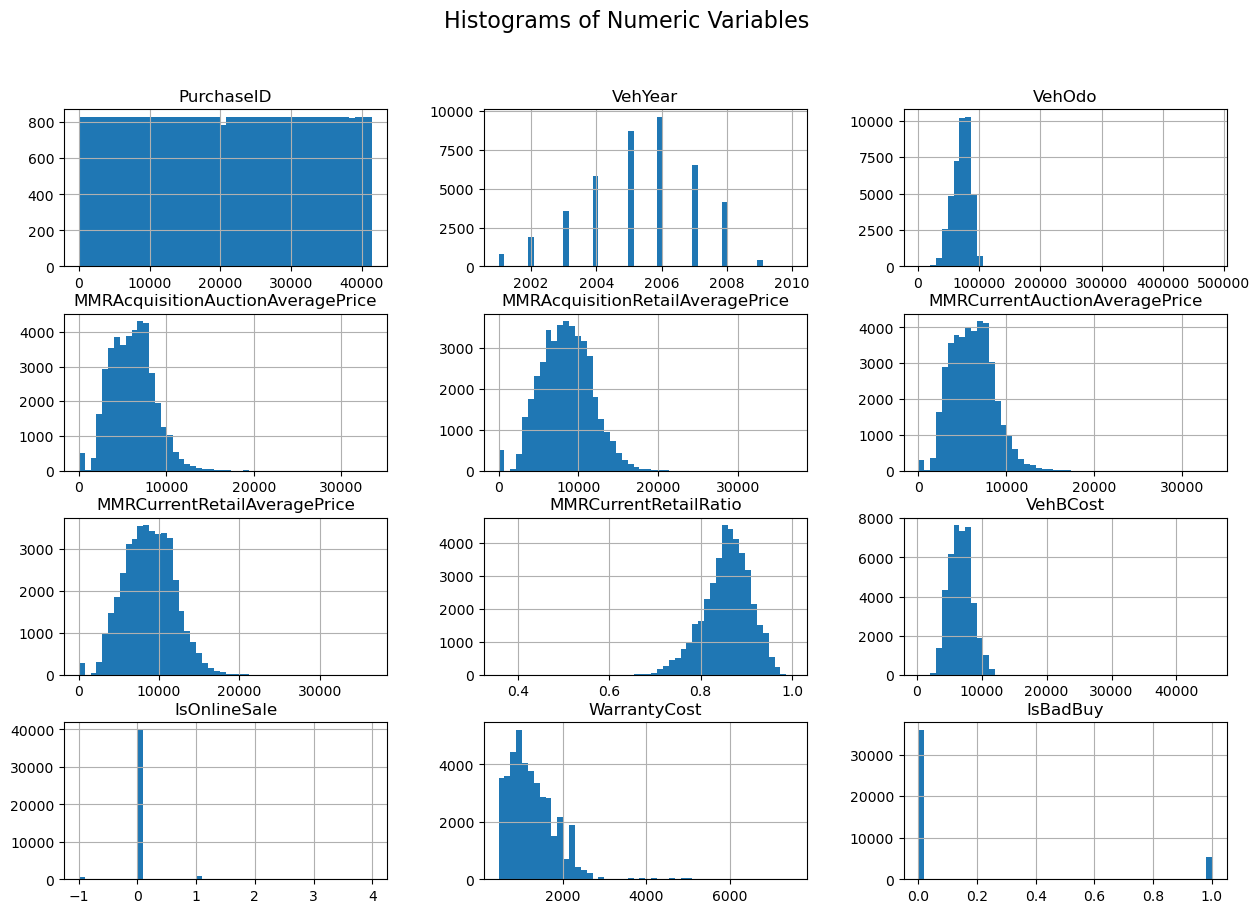

In [ ]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

df[numeric_cols].hist(bins=50, figsize=(15, 10))
plt.suptitle("Histograms of Numeric Variables", fontsize=16)
plt.show()